In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True,
                     "font.size": 14,
                     "pdf.fonttype": 42,
                     "ps.fonttype": 42})
                     

In [2]:
def extractWinAroundMax(df, win_len=100):
  nrep = df['iter'].max()
  pruned_df = pd.DataFrame()
  for idx in range(nrep):
    try:
      idx_max_t = df[df['iter'] == idx+1]['latency'].idxmax()
      if idx_max_t<80:
        continue
      pruned_df = pd.concat([pruned_df, df.iloc[idx_max_t-win_len:idx_max_t+win_len,0:5]])
    except:
      pass
  return pruned_df

conf_perc_str = "99.9" #90%:1.645|95%:1.96|97%:2.17|99%:2.576|99.9%:3.29
  
def plot_confidence_interval_df(plt, stats_df, columnName, x_axis, color, coeff=1.96, norm=1):
  if columnName == "":
    subset_stats = stats_df[["mean", "count", "std"]]
  else:
    subset_stats = stats_df[["mean("+str(columnName)+")",
                             "count("+str(columnName)+")",
                             "std("+str(columnName)+")"]]
  norm_mean = []
  ci_high = []
  ci_low = []

  if (isinstance(norm, pd.DataFrame) or isinstance(norm, pd.Series)):
    if (len(stats_df["mean("+str(columnName)+")"].index) == len(norm.index)):
      for i in subset_stats.index:
        mean, count, std = subset_stats.loc[i]
        mean = mean/norm.loc[i]
        std = std/norm.loc[i]
        norm_mean.append(mean)
        ci_high.append(mean + coeff*std/np.sqrt(count))
        ci_low.append(mean - coeff*std/np.sqrt(count))
  else:
    for i in subset_stats.index:
      mean, count, std = subset_stats.loc[i]
      mean = mean/norm
      std = std/norm
      norm_mean.append(mean)
      ci_high.append(mean + coeff*std/np.sqrt(count))
      ci_low.append(mean - coeff*std/np.sqrt(count))

  plt.fill_between(x_axis, norm_mean, ci_high, alpha=0.3, color=color)
  plt.fill_between(x_axis, ci_low, norm_mean, alpha=0.3, color=color)

def filterByScenario (df_op):
  scenario_list=["ns_clear", "scp_ckpt", "create_ns", "clear_arp"]
  filtered_df=pd.DataFrame()
  #filtered_df["iter"]=df_op["iter"].unique()
  for scenario in scenario_list:
    filtered_df[scenario] = df_op[df_op["scenario"] == scenario].reset_index()["elapsed"]
  return filtered_df

def mergeSockperfStats (df_latency, df_state, df_op, df_dump, df_restore):
  merged_df = pd.DataFrame()
  merged_df['iter'] = df_state["iter"]
  merged_df = pd.concat([merged_df, df_latency.groupby(['iter']).agg(max=('latency', 'max')).reset_index()['max']], axis="columns")
  merged_df = pd.concat([merged_df, df_state["memory_MB"]], axis="columns")
  merged_df = pd.concat([merged_df, filterByScenario(df_op)], axis="columns")
  df_dump_t = df_dump.drop("container_id", axis=1).drop("iter", axis=1)
  merged_df = pd.concat([merged_df, df_dump_t], axis="columns")
  df_restore_t = df_restore.drop("container_id", axis=1).drop("iter", axis=1)
  merged_df = pd.concat([merged_df, df_restore_t], axis="columns")
  return merged_df.rename({'max': 'max_latency', 'memory_MB': 'memory'}, axis='columns')

In [3]:
half_win_size =80

PATH = "../log/sockperf_triple_latency_ctl2/"

header_t = pd.read_csv(PATH + "sockperf.csv", sep=',', nrows=5)
dtypes = dict(zip(header_t.columns.values, ['uint16', 'uint16', 'float64', 'float64', 'float64']))
del header_t

raw_nonarp_df = pd.read_csv(PATH + "sockperf.csv", sep=',', dtype=dtypes)
raw_nonarp_df
pruned_nonarp_df = extractWinAroundMax(raw_nonarp_df, half_win_size).reset_index()

In [4]:
pruned_nonarp_df["RTT"]= pruned_nonarp_df["latency"]*2/1000

df = pruned_nonarp_df[["iter","RTT"]]
df

,iter,RTT
0,1,23.445092
1,1,23.150328
2,1,23.596180
3,1,23.427216
4,1,23.383494
...,...,...
7930,50,5.273494
7931,50,5.084112
7932,50,5.352436
7933,50,5.268510


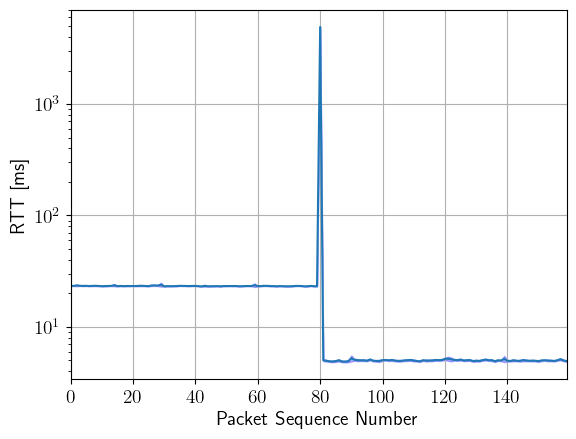

In [5]:
pruned_nonarp_df["RTT"]= pruned_nonarp_df["latency"]*2/1000

df = pruned_nonarp_df[["iter","RTT"]]
df_groups = df.groupby("iter")

avg = []
std = []
ci = [] # 90% CI
data= []
for i in df_groups.groups.keys():
    group = df_groups.get_group(i)
    value = group["RTT"].values
    if len(value)==half_win_size*2 and value[half_win_size]>1000:
        data.append(value)
data_array = np.array(data,np.float32)
for i in range(half_win_size*2):
    avg.append(data_array[:,i].mean())
    std.append(data_array[:,i].std())
    ci.append(1.645 *data_array[:,i].std()/np.sqrt(len(data_array[:,i])))



x_real = np.arange(0,half_win_size*2,1)
fig, ax = plt.subplots()
ax.plot(x_real,avg)
ax.fill_between(x_real, (np.array(avg)-np.array(ci)), (np.array(avg)+np.array(ci)), color='b', alpha=.3)
ax.set_yscale("log")
ax.set_ylabel("RTT [ms]")
ax.set_xlabel("Packet Sequence Number")
ax.grid()
ax.autoscale(enable=True, axis='x', tight=True)
fig.savefig("../figures/latency.pdf",format="pdf")

In [6]:
raw_sockperf_non_arp_latency_df = pruned_nonarp_df
raw_sockperf_non_arp_state_df = pd.read_csv(PATH + "container_state.csv", sep=',')
raw_sockperf_non_arp_op_df = pd.read_csv(PATH + "sockperf_op_time.csv", sep=',')
raw_sockperf_non_arp_dump_df = pd.read_csv(PATH + "podman_dump.csv", sep=',')
raw_sockperf_non_arp_restore_df = pd.read_csv(PATH + "podman_restore.csv", sep=',')
sockperf_non_arp_df = mergeSockperfStats(raw_sockperf_non_arp_latency_df, raw_sockperf_non_arp_state_df, raw_sockperf_non_arp_op_df, raw_sockperf_non_arp_dump_df, raw_sockperf_non_arp_restore_df)


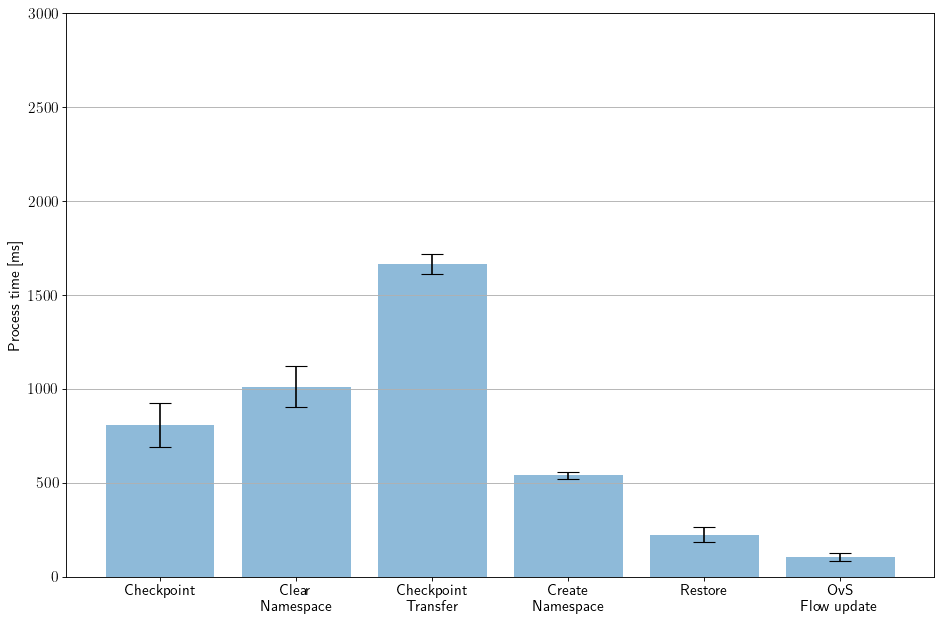

In [7]:


df = pd.DataFrame()

# df["iter"] = sockperf_non_arp_df["iter"]
df["RTT"]= sockperf_non_arp_df["max_latency"]*2/1000
df[["ns_clear","scp_ckpt","create_ns"]] = sockperf_non_arp_df[["ns_clear","scp_ckpt","create_ns"]]*1000
df[["checkpoint","restore"]] = sockperf_non_arp_df[["podman_checkpoint_duration","podman_restore_duration"]]/1000
df["clear_arp"] = sockperf_non_arp_df["clear_arp"]*1000
drop_index = []

for i in range(len(df)):
    if(df.iloc[i]["RTT"]<1000 or df.iloc[i]["ns_clear"]>3000 ):
        drop_index.append(i)
df.drop(drop_index, axis=0, inplace=True)


df_plot = df[["checkpoint","ns_clear","scp_ckpt","create_ns","restore","clear_arp"]]
mean_data = df_plot.mean().values
std = df_plot.std().values
x_label = ["Checkpoint","Clear\nNamespace","Checkpoint\nTransfer","Create\nNamespace","Restore","OvS\nFlow update"]
x_pos = np.arange(len(x_label))
fig, ax = plt.subplots(figsize=(12, 8), dpi=80)
ax.bar(x_pos,mean_data , yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Process time [ms]')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label)
ax.yaxis.grid(True)
ax.set_ylim([0,3000])
# ax.set_yscale("log")
# Save the figure and show
plt.tight_layout()
plt.show()